In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import re
import nltk
import pickle
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import numpy as np
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import math
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/NewsCategorizer.csv")

data.head()

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


In [ ]:
print("Total Rows = ", data.shape[0])

Total Rows =  50000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  50000 non-null  object
 4   keywords           47332 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


In [ ]:
print("Number of duplicate headlines and short_description = ", data.duplicated(['headline','short_description'], keep = 'last').sum())

Number of duplicate headlines and short_description =  4251


In [ ]:
data.drop_duplicates(['headline','short_description'], keep = 'last', inplace = True)

In [ ]:
data.isnull().sum()

category                0
headline                0
links                   0
short_description       0
keywords             2379
dtype: int64

In [ ]:
data = data.dropna(subset=['keywords'])

In [ ]:
data[data['headline'] == '']

,category,headline,links,short_description,keywords


In [ ]:
data[data['short_description'] == '']

,category,headline,links,short_description,keywords


In [ ]:
print("Number of categories = ",data['category'].nunique())
data['category'].value_counts()

Number of categories =  10


TRAVEL            4865
FOOD & DRINK      4863
ENTERTAINMENT     4855
WORLD NEWS        4851
WELLNESS          4741
POLITICS          4712
STYLE & BEAUTY    4708
PARENTING         4466
BUSINESS          2782
SPORTS            2527
Name: category, dtype: int64

In [ ]:
word_len = [len(headline.split()) for headline in data["headline"] if headline.strip()]
minindex = min(word_len)
minindex = word_len.index(minindex)
print(minindex)


252


In [ ]:
data.iloc[252]

category                                                      WELLNESS
headline                                                    Creativity
links                https://www.huffingtonpost.com/entry/creativit...
short_description    If you wish to change your personality or writ...
keywords                                                    creativity
Name: 263, dtype: object

In [ ]:
word_len = [len(short_description.split()) for short_description in data["short_description"] if short_description.strip()]  # Exclude empty headlines
minindex = min(word_len)
minindex = word_len.index(minindex)
print(minindex)

5507


In [ ]:
data.iloc[5507]

category                                                      POLITICS
headline             West Virginia Governor Brings Out Actual Bulls...
links                https://www.huffingtonpost.com/entry/jim-justi...
short_description                                                    💩
keywords                                       jim-justice-budget-bill
Name: 5812, dtype: object

In [ ]:
data['full_article'] = data['headline'] + " " + data['short_description']
data.head()

,category,headline,links,short_description,keywords,full_article
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons,143 Miles in 35 Days: Lessons Learned Resting ...
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy,Talking to Yourself: Crazy or Crazy Helpful? T...
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug,Crenezumab: Trial Will Gauge Whether Alzheimer...
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life,"Oh, What a Difference She Made If you want to ..."
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods,"Green Superfoods First, the bad news: Soda bre..."


In [ ]:
data['news_len'] = data['full_article'].apply(lambda x: len(x))
data.head()

,category,headline,links,short_description,keywords,full_article,news_len
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons,143 Miles in 35 Days: Lessons Learned Resting ...,318
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy,Talking to Yourself: Crazy or Crazy Helpful? T...,261
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug,Crenezumab: Trial Will Gauge Whether Alzheimer...,206
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life,"Oh, What a Difference She Made If you want to ...",137
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods,"Green Superfoods First, the bad news: Soda bre...",142


In [ ]:
data.groupby('category')['news_len'].mean().reset_index().sort_values(by='news_len',ascending=False)

,category,news_len
8,WELLNESS,232.736553
3,PARENTING,225.634124
0,BUSINESS,219.361251
7,TRAVEL,213.577801
6,STYLE & BEAUTY,192.649958
9,WORLD NEWS,189.858792
4,POLITICS,184.060272
1,ENTERTAINMENT,161.936354
5,SPORTS,158.156312
2,FOOD & DRINK,151.783673


{'whiskers': [<matplotlib.lines.Line2D at 0x79fe15f08e20>,
 'caps': [<matplotlib.lines.Line2D at 0x79fe15f09360>,
 'boxes': [<matplotlib.lines.Line2D at 0x79fe15f08b80>],
 'medians': [<matplotlib.lines.Line2D at 0x79fe15f098a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x79fe15f09b40>],
 'means': []}

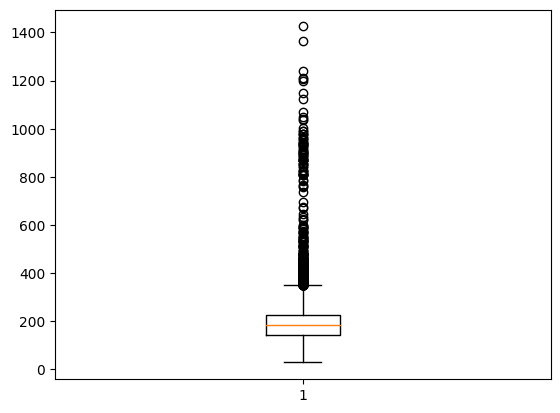

In [ ]:
plt.boxplot(data['news_len'])

In [ ]:
data.reset_index(inplace = True, drop = True)
count = 0
max_threshold = data['news_len'].std() *3 + data['news_len'].mean()
min_threshold = abs(data['news_len'].mean() - data['news_len'].std()*3)
for num in data['news_len']:
    if num > max_threshold or num < min_threshold:
      count += 1
print("The total outliers are = ",count)

The total outliers are =  231


In [ ]:
data = data[(data['news_len'] < max_threshold) & (data['news_len'] > min_threshold )]
data.shape

(43139, 7)

In [ ]:
data.iloc[5507]

category                                                      POLITICS
headline             Bernie Sanders Will Introduce Legislation To E...
links                https://www.huffingtonpost.com/entry/bernie-sa...
short_description     He also wants to do more to help former inmates.
keywords                                bernie-sanders-private-prisons
full_article         Bernie Sanders Will Introduce Legislation To E...
news_len                                                           113
Name: 5529, dtype: object

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()

    tokens = nltk.word_tokenize(text)

    tokens = [token for token in tokens if token.isalpha()]

    tokens = [token for token in tokens if token not in stop_words]

    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [ ]:
data['keywords'] = data['keywords'].str.replace('-', ' ')

In [ ]:
data.loc[:, ('full_article_tokens')] = data.loc[:,('full_article')].apply(lambda x: preprocess(x))
data.loc[:,('keywords_tokens')]=data.loc[:,('keywords')].apply(lambda x: preprocess(x))

In [ ]:
data

,category,headline,links,short_description,keywords,full_article,news_len,full_article_tokens,keywords_tokens
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running lessons,143 Miles in 35 Days: Lessons Learned Resting ...,318,"[mile, day, lesson, learned, resting, part, tr...","[running, lesson]"
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking to yourself crazy,Talking to Yourself: Crazy or Crazy Helpful? T...,261,"[talking, crazy, crazy, helpful, think, talkin...","[talking, crazy]"
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab alzheimers disease drug,Crenezumab: Trial Will Gauge Whether Alzheimer...,206,"[crenezumab, trial, gauge, whether, alzheimer,...","[crenezumab, alzheimers, disease, drug]"
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful life,"Oh, What a Difference She Made If you want to ...",137,"[oh, difference, made, want, busy, keep, tryin...","[meaningful, life]"
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green superfoods,"Green Superfoods First, the bad news: Soda bre...",142,"[green, superfoods, first, bad, news, soda, br...","[green, superfoods]"
...,...,...,...,...,...,...,...,...,...
43365,SPORTS,Norovirus Outbreak At Winter Olympics Prompts ...,https://www.huffingtonpost.com/entry/norovirus...,Troops will replace hundreds of civilian secur...,norovirus outbreak at winter olympics prompts ...,Norovirus Outbreak At Winter Olympics Prompts ...,159,"[norovirus, outbreak, winter, olympics, prompt...","[norovirus, outbreak, winter, olympics, prompt..."
43366,SPORTS,This Baseball Team Learned There's A Wrong Way...,https://www.huffingtonpost.com/entry/san-jose-...,Many fans were pissed after seeing the minor l...,san jose giants japanese heritage night,This Baseball Team Learned There's A Wrong Way...,152,"[baseball, team, learned, wrong, way, celebrat...","[san, jose, giant, japanese, heritage, night]"
43367,SPORTS,Some Young Spurs Fan Dabbed 38 Times In A Sing...,https://www.huffingtonpost.com/entry/dab-kid-s...,"Never change, young man. Never change.",dab kid san antonio spurs,Some Young Spurs Fan Dabbed 38 Times In A Sing...,100,"[young, spur, fan, dabbed, time, single, playo...","[dab, kid, san, antonio, spur]"
43368,SPORTS,Rasheed Wallace Ejected From Knicks-Suns Game ...,https://www.huffingtonpost.com/entry/rasheed-w...,Wallace was hit with a first technical for a h...,rasheed wallace ejected knicks suns ball dont lie,Rasheed Wallace Ejected From Knicks-Suns Game ...,206,"[rasheed, wallace, ejected, game, yelling, lie...","[rasheed, wallace, ejected, knicks, sun, ball,..."


In [ ]:
unique_categories = data["category"].unique()
unique_categories=list(unique_categories)
unique_categories

['WELLNESS',
 'POLITICS',
 'ENTERTAINMENT',
 'TRAVEL',
 'STYLE & BEAUTY',
 'PARENTING',
 'FOOD & DRINK',
 'WORLD NEWS',
 'BUSINESS',
 'SPORTS']

In [ ]:
categories_news_string = {}
for category in unique_categories:
    category_articles = list (data[data['category'] == category]['full_article_tokens'])
    categories_news_string[category] = list(np.concatenate(category_articles))

all_articles = pd.DataFrame(categories_news_string.items(), columns=['Category', 'News_tokens'])
all_articles

,Category,News_tokens
0,WELLNESS,"[mile, day, lesson, learned, resting, part, tr..."
1,POLITICS,"[gop, congressman, suggests, looser, standard,..."
2,ENTERTAINMENT,"[paul, mccartney, nirvana, surviving, member, ..."
3,TRAVEL,"[remembering, christopher, mccandless, year, l..."
4,STYLE & BEAUTY,"[give, hand, work, darn, hard, whether, franti..."
5,PARENTING,"[need, need, viral, video, metaphor, parenting..."
6,FOOD & DRINK,"[chef, guide, portland, go, beyond, lobster, r..."
7,WORLD NEWS,"[gunman, attack, indian, air, force, base, nea..."
8,BUSINESS,"[david, weber, sec, investigator, leave, previ..."
9,SPORTS,"[corey, dickerson, hit, double, bounce, pitch,..."


In [ ]:
categories_news_string = {}
for category in unique_categories:
    category_articles = list (data[data['category'] == category]['keywords_tokens'])
    categories_news_string[category] = list(np.concatenate(category_articles))

all_keywords = pd.DataFrame(categories_news_string.items(), columns=['Category', 'key_tokens'])
all_keywords

,Category,key_tokens
0,WELLNESS,"[running, lesson, talking, crazy, crenezumab, ..."
1,POLITICS,"[zeldin, muslim, reasonable, suspicion, ohio, ..."
2,ENTERTAINMENT,"[paul, mccartney, nirvana, seattle, tenacious,..."
3,TRAVEL,"[remembering, christopher, mccandless, start, ..."
4,STYLE & BEAUTY,"[give, chambray, dress, david, beckham, kid, h..."
5,PARENTING,"[need, dont, need, video, pitfall, helicopte, ..."
6,FOOD & DRINK,"[find, eat, drink, chef, guide, portland, shri..."
7,WORLD NEWS,"[gunman, attack, indian, air, force, base, nea..."
8,BUSINESS,"[david, weber, sec, investigator, learn, inves..."
9,SPORTS,"[corey, dickerson, double, bounce, pitch, uswn..."


In [ ]:
all_articles.loc[:, ('unigram_Frequencies')] = all_articles['News_tokens'].apply(lambda x: nltk.FreqDist(x))
all_keywords.loc[:, ('unigram_Frequencies')] = all_keywords['key_tokens'].apply(lambda x: nltk.FreqDist(x))
print(all_articles.head())
all_keywords.head()

         Category                                        News_tokens  \
0        WELLNESS  [mile, day, lesson, learned, resting, part, tr...   
1        POLITICS  [gop, congressman, suggests, looser, standard,...   
2   ENTERTAINMENT  [paul, mccartney, nirvana, surviving, member, ...   
3          TRAVEL  [remembering, christopher, mccandless, year, l...   
4  STYLE & BEAUTY  [give, hand, work, darn, hard, whether, franti...   

                                 unigram_Frequencies  
0  {'mile': 20, 'day': 467, 'lesson': 76, 'learne...  
1  {'gop': 377, 'congressman': 59, 'suggests': 10...  
2  {'paul': 59, 'mccartney': 17, 'nirvana': 7, 's...  
3  {'remembering': 4, 'christopher': 5, 'mccandle...  
4  {'give': 94, 'hand': 40, 'work': 96, 'darn': 6...  


,Category,key_tokens,unigram_Frequencies
0,WELLNESS,"[running, lesson, talking, crazy, crenezumab, ...","{'running': 23, 'lesson': 61, 'talking': 4, 'c..."
1,POLITICS,"[zeldin, muslim, reasonable, suspicion, ohio, ...","{'zeldin': 1, 'muslim': 22, 'reasonable': 1, '..."
2,ENTERTAINMENT,"[paul, mccartney, nirvana, seattle, tenacious,...","{'paul': 33, 'mccartney': 12, 'nirvana': 3, 's..."
3,TRAVEL,"[remembering, christopher, mccandless, start, ...","{'remembering': 1, 'christopher': 1, 'mccandle..."
4,STYLE & BEAUTY,"[give, chambray, dress, david, beckham, kid, h...","{'give': 6, 'chambray': 1, 'dress': 212, 'davi..."


In [ ]:
keys=[]
keys1=[]

In [ ]:
for (articles,category) in zip(all_articles['unigram_Frequencies'], all_articles['Category']):
    print(category)
    keys.append(articles.most_common(10))
    print(articles.most_common(10))

WELLNESS
[('life', 871), ('health', 633), ('time', 621), ('one', 591), ('way', 558), ('people', 550), ('study', 504), ('u', 491), ('day', 467), ('new', 443)]
POLITICS
[('state', 542), ('republican', 478), ('say', 435), ('new', 422), ('gop', 377), ('obama', 358), ('american', 345), ('clinton', 345), ('people', 334), ('bill', 332)]
ENTERTAINMENT
[('new', 708), ('film', 470), ('movie', 402), ('show', 387), ('one', 378), ('year', 357), ('star', 351), ('first', 323), ('say', 316), ('like', 285)]
TRAVEL
[('photo', 987), ('travel', 907), ('world', 704), ('hotel', 627), ('new', 591), ('one', 569), ('best', 545), ('city', 524), ('day', 446), ('place', 437)]
STYLE & BEAUTY
[('photo', 2752), ('style', 976), ('fashion', 954), ('look', 803), ('week', 708), ('new', 623), ('check', 552), ('dress', 513), ('want', 461), ('day', 414)]
PARENTING
[('child', 1444), ('kid', 1299), ('parent', 945), ('mom', 676), ('baby', 635), ('one', 612), ('time', 575), ('day', 557), ('family', 439), ('like', 438)]
FOOD & 

In [ ]:
for (keyword,category) in zip(all_keywords['unigram_Frequencies'], all_keywords['Category']):
    print(category)
    keys1.append(keyword.most_common(10))
    print(keyword.most_common(10))

WELLNESS
[('health', 285), ('tip', 177), ('cancer', 174), ('life', 154), ('weight', 139), ('sleep', 135), ('healthy', 115), ('meditation', 111), ('food', 109), ('stress', 103)]
POLITICS
[('clinton', 196), ('obama', 174), ('republican', 171), ('hillary', 154), ('sander', 134), ('bill', 134), ('gop', 133), ('bernie', 119), ('court', 117), ('senate', 112)]
ENTERTAINMENT
[('new', 175), ('movie', 139), ('star', 135), ('trailer', 133), ('taylor', 111), ('swift', 103), ('dead', 99), ('kardashian', 96), ('season', 94), ('show', 91)]
TRAVEL
[('travel', 442), ('best', 260), ('hotel', 235), ('world', 178), ('new', 137), ('top', 111), ('photo', 111), ('airline', 109), ('america', 102), ('place', 91)]
STYLE & BEAUTY
[('photo', 796), ('style', 370), ('fashion', 328), ('dress', 212), ('hair', 204), ('kate', 178), ('week', 169), ('picture', 146), ('beauty', 129), ('middleton', 123)]
PARENTING
[('kid', 441), ('baby', 259), ('child', 229), ('mom', 219), ('parent', 197), ('parenting', 180), ('day', 157),

In [ ]:
fig = px.pie(data, names='category', title='Category Distribution')
fig.show()

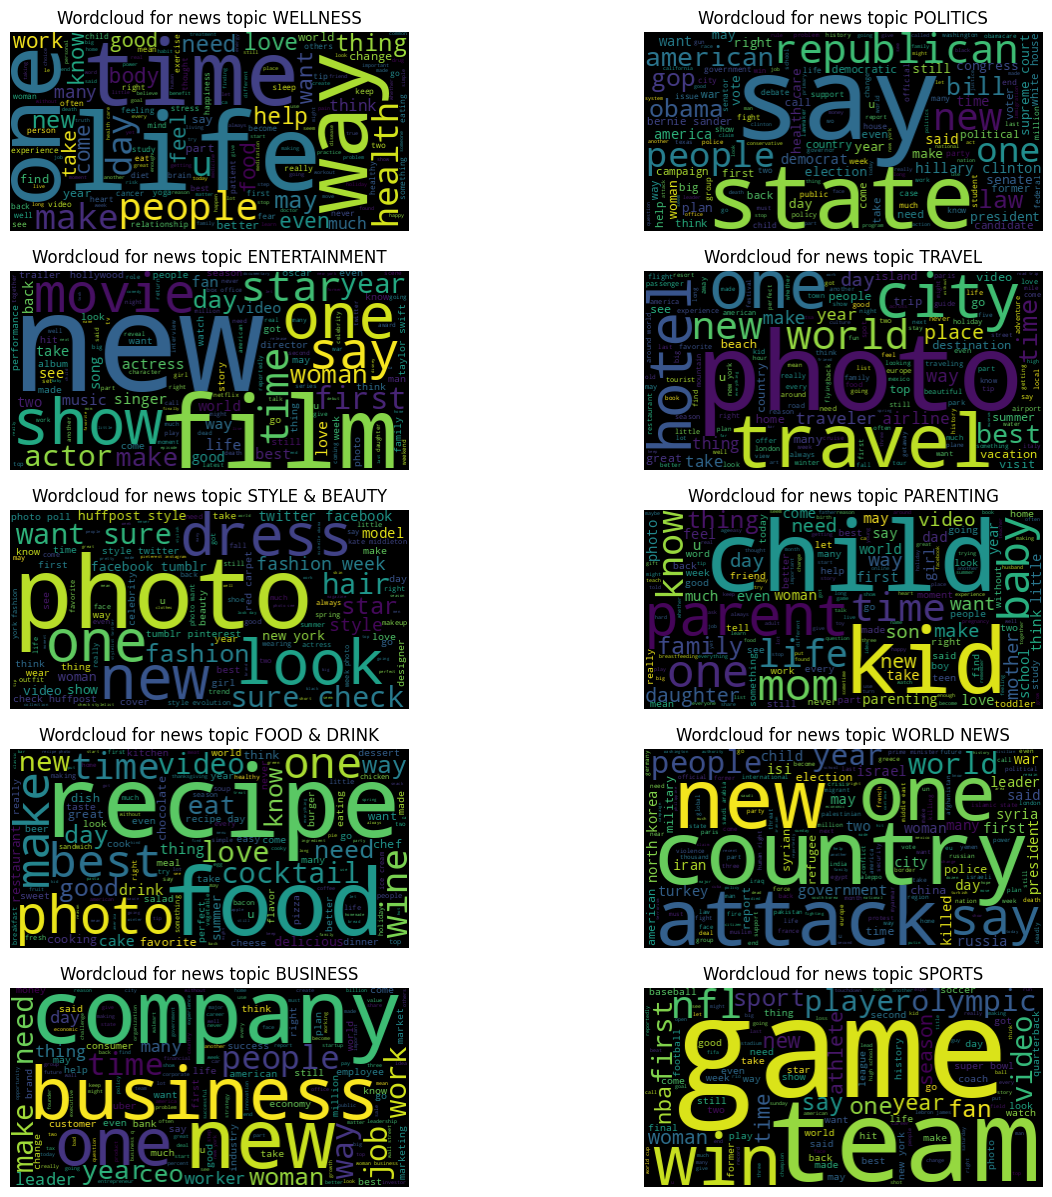

In [ ]:
plt.figure(figsize=(15,15))

for i, category in enumerate(unique_categories):
    plt.subplot(5,2,i+1)
    cloud = WordCloud().generate(' '.join(all_articles['News_tokens'][i]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {category}")
    plt.axis('off')

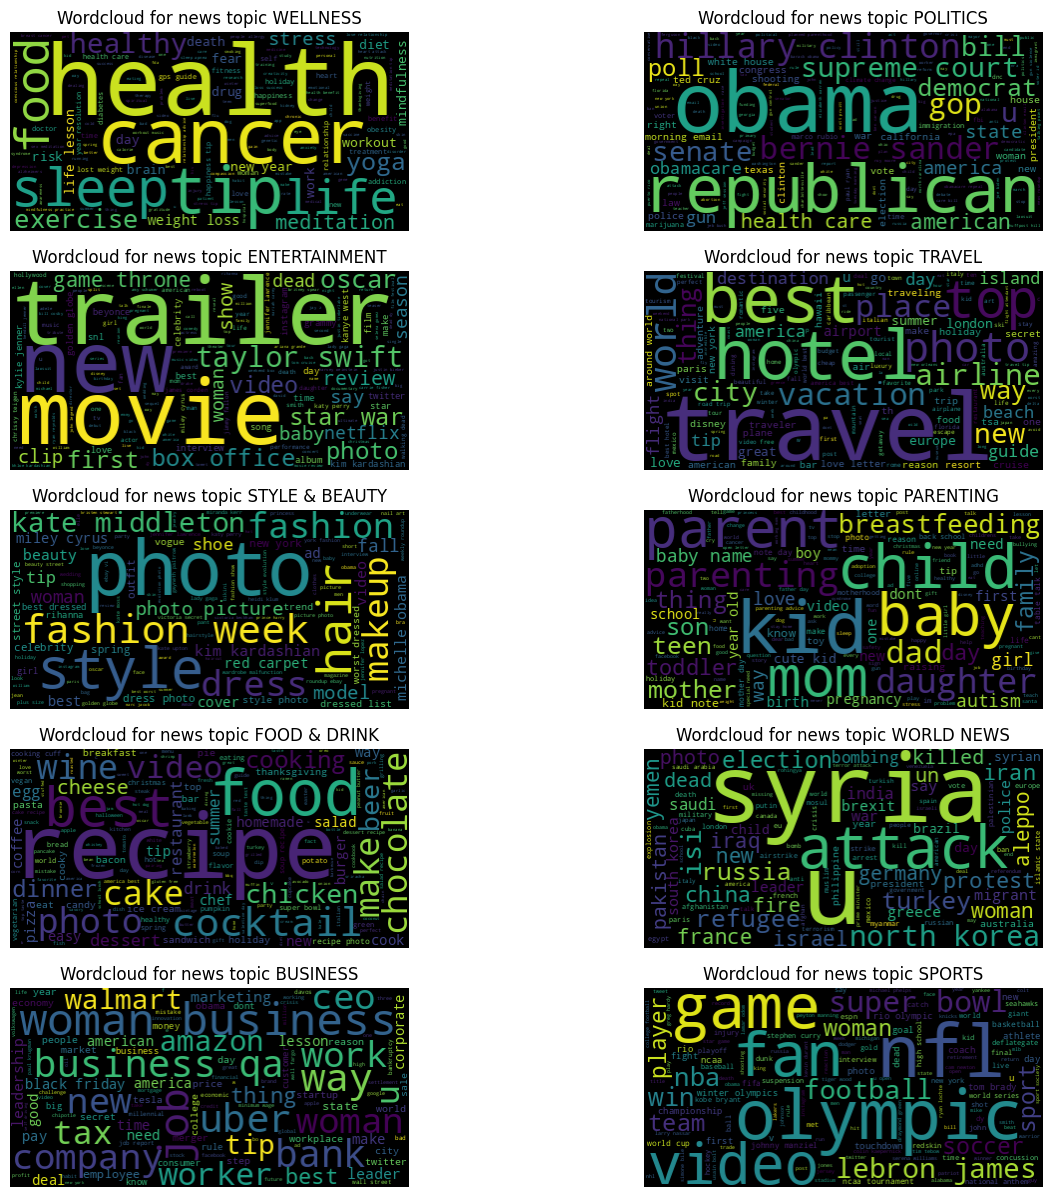

In [ ]:
plt.figure(figsize=(15,15))

for i, category in enumerate(unique_categories):
    plt.subplot(5,2,i+1)
    cloud = WordCloud().generate(' '.join(all_keywords['key_tokens'][i]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {category}")
    plt.axis('off')

<ipython-input-37-8a54be59fc17>:13: UserWarning:

FixedFormatter should only be used together with FixedLocator



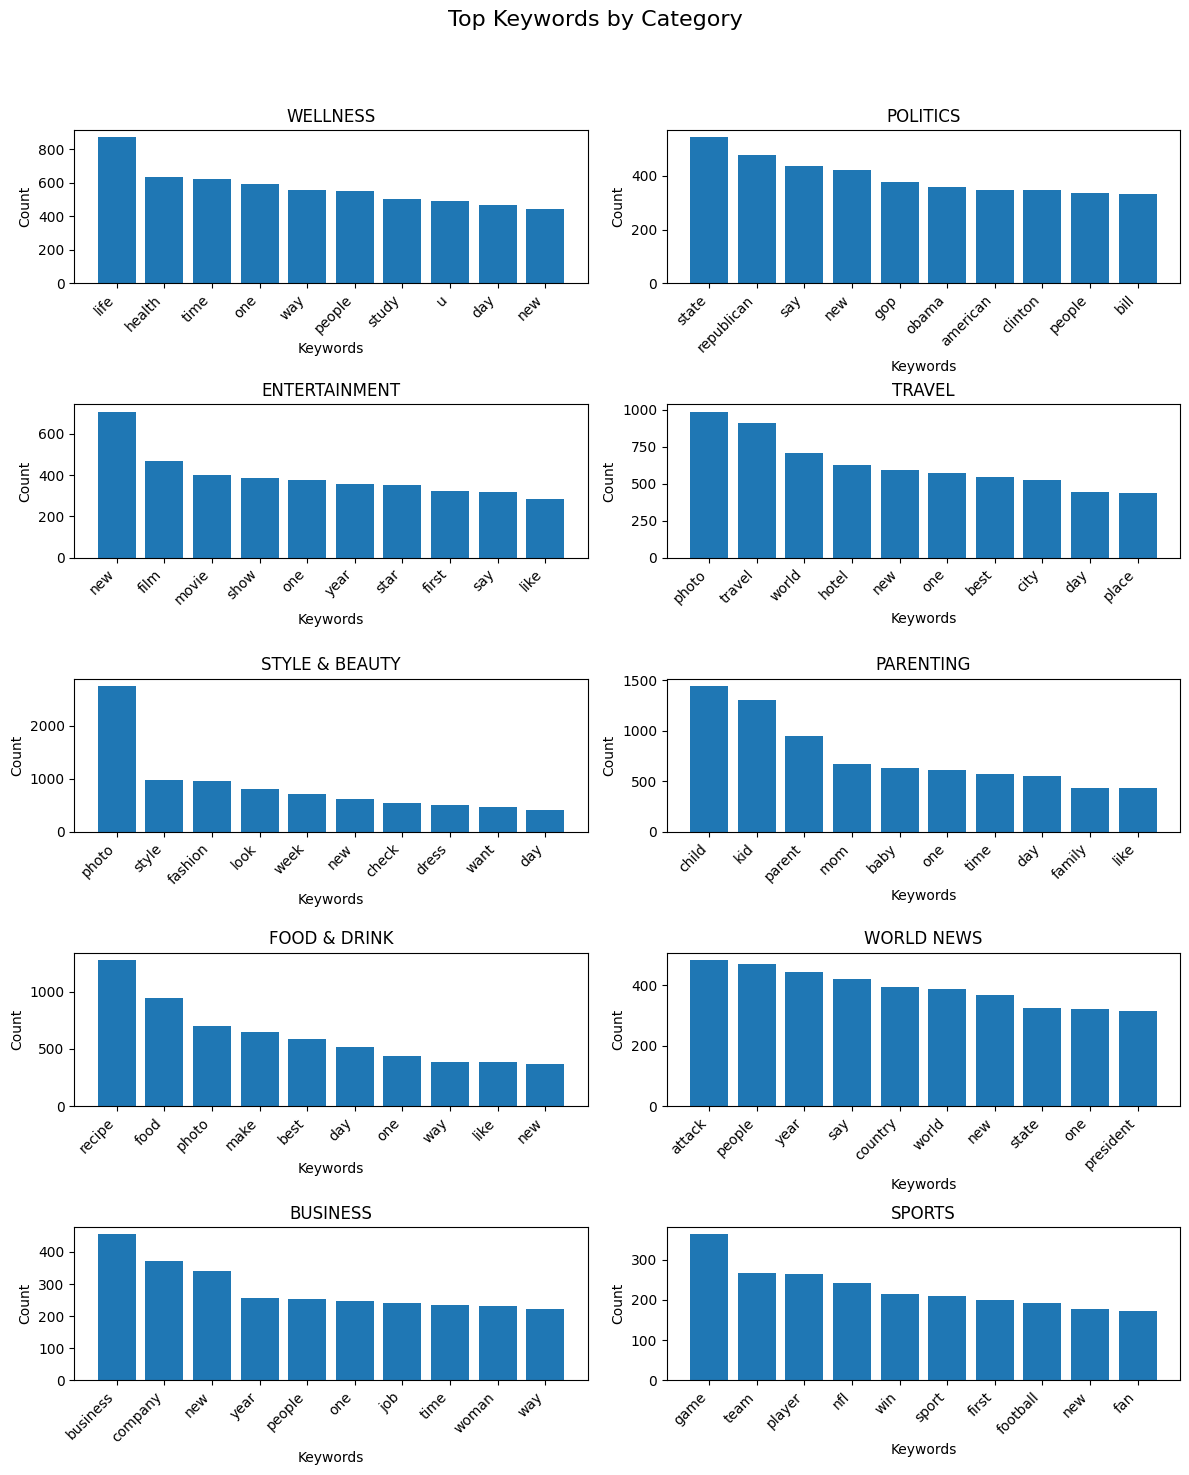

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
fig.suptitle('Top Keywords by Category', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i < len(unique_categories):
        category = unique_categories[i]
        category_keywords = keys[i]
        top_keywords = [item[0] for item in category_keywords]
        counts = [item[1] for item in category_keywords]

        ax.bar(top_keywords, counts)
        ax.set_title(category)
        ax.set_xticklabels(top_keywords, rotation=45, ha="right")
        ax.set_xlabel('Keywords')
        ax.set_ylabel('Count')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

<ipython-input-38-3ad825075e03>:13: UserWarning:

FixedFormatter should only be used together with FixedLocator



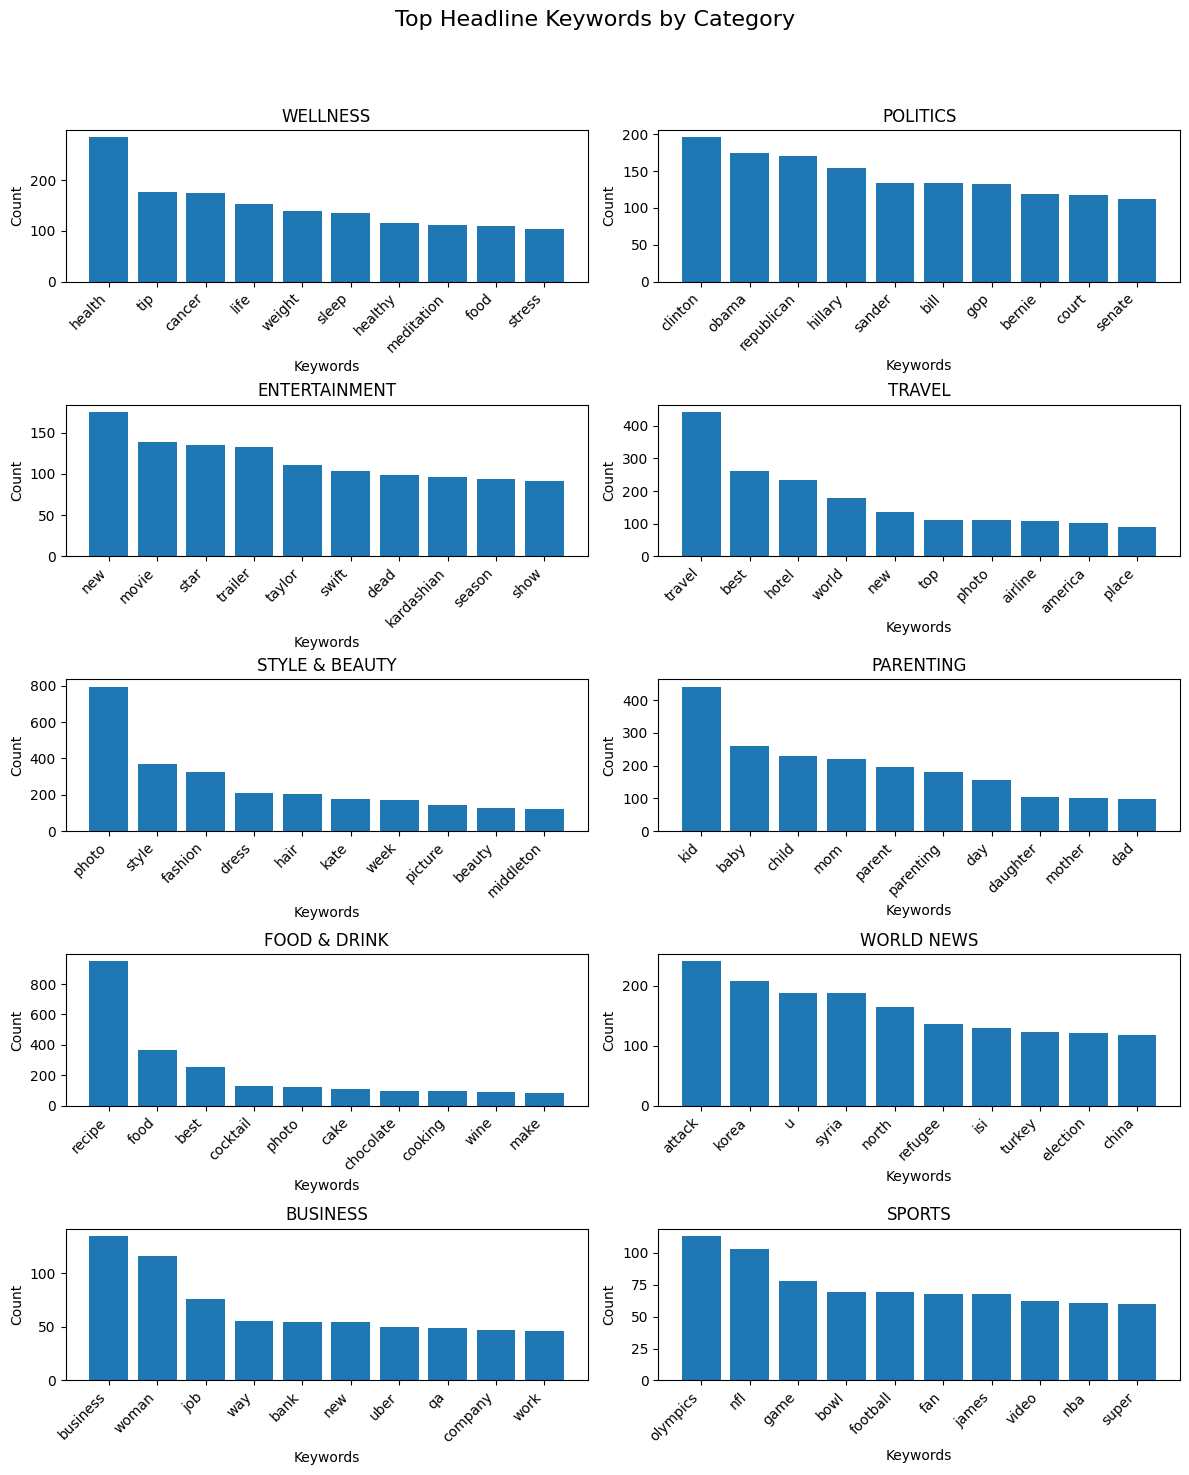

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
fig.suptitle('Top Headline Keywords by Category', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i < len(unique_categories):
        category = unique_categories[i]
        category_keywords = keys1[i]
        top_keywords = [item[0] for item in category_keywords]
        counts = [item[1] for item in category_keywords]

        ax.bar(top_keywords, counts)
        ax.set_title(category)
        ax.set_xticklabels(top_keywords, rotation=45, ha="right")
        ax.set_xlabel('Keywords')
        ax.set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
data["category"].value_counts()

FOOD & DRINK      4855
ENTERTAINMENT     4849
TRAVEL            4832
WORLD NEWS        4770
WELLNESS          4726
STYLE & BEAUTY    4697
POLITICS          4667
PARENTING         4457
BUSINESS          2762
SPORTS            2524
Name: category, dtype: int64

In [ ]:
label_encoder=LabelEncoder()
data["category"]=label_encoder.fit_transform(data["category"])
data

,category,headline,links,short_description,keywords,full_article,news_len,full_article_tokens,keywords_tokens
0,8,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running lessons,143 Miles in 35 Days: Lessons Learned Resting ...,318,"[mile, day, lesson, learned, resting, part, tr...","[running, lesson]"
1,8,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking to yourself crazy,Talking to Yourself: Crazy or Crazy Helpful? T...,261,"[talking, crazy, crazy, helpful, think, talkin...","[talking, crazy]"
2,8,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab alzheimers disease drug,Crenezumab: Trial Will Gauge Whether Alzheimer...,206,"[crenezumab, trial, gauge, whether, alzheimer,...","[crenezumab, alzheimers, disease, drug]"
3,8,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful life,"Oh, What a Difference She Made If you want to ...",137,"[oh, difference, made, want, busy, keep, tryin...","[meaningful, life]"
4,8,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green superfoods,"Green Superfoods First, the bad news: Soda bre...",142,"[green, superfoods, first, bad, news, soda, br...","[green, superfoods]"
...,...,...,...,...,...,...,...,...,...
43365,5,Norovirus Outbreak At Winter Olympics Prompts ...,https://www.huffingtonpost.com/entry/norovirus...,Troops will replace hundreds of civilian secur...,norovirus outbreak at winter olympics prompts ...,Norovirus Outbreak At Winter Olympics Prompts ...,159,"[norovirus, outbreak, winter, olympics, prompt...","[norovirus, outbreak, winter, olympics, prompt..."
43366,5,This Baseball Team Learned There's A Wrong Way...,https://www.huffingtonpost.com/entry/san-jose-...,Many fans were pissed after seeing the minor l...,san jose giants japanese heritage night,This Baseball Team Learned There's A Wrong Way...,152,"[baseball, team, learned, wrong, way, celebrat...","[san, jose, giant, japanese, heritage, night]"
43367,5,Some Young Spurs Fan Dabbed 38 Times In A Sing...,https://www.huffingtonpost.com/entry/dab-kid-s...,"Never change, young man. Never change.",dab kid san antonio spurs,Some Young Spurs Fan Dabbed 38 Times In A Sing...,100,"[young, spur, fan, dabbed, time, single, playo...","[dab, kid, san, antonio, spur]"
43368,5,Rasheed Wallace Ejected From Knicks-Suns Game ...,https://www.huffingtonpost.com/entry/rasheed-w...,Wallace was hit with a first technical for a h...,rasheed wallace ejected knicks suns ball dont lie,Rasheed Wallace Ejected From Knicks-Suns Game ...,206,"[rasheed, wallace, ejected, game, yelling, lie...","[rasheed, wallace, ejected, knicks, sun, ball,..."


In [ ]:
data["category"].value_counts()

2    4855
1    4849
7    4832
9    4770
8    4726
6    4697
4    4667
3    4457
0    2762
5    2524
Name: category, dtype: int64

In [ ]:
X=data["headline"]
Y=data["category"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train the Multinomial Naive Bayes model
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_tfidf)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Generate a classification report
class_report = classification_report(y_test, y_pred, target_names=unique_categories)
print(class_report)

# Display a confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

Accuracy: 0.72
                precision    recall  f1-score   support

      WELLNESS       0.91      0.19      0.32       559
      POLITICS       0.66      0.78      0.71       952
 ENTERTAINMENT       0.80      0.85      0.83       975
        TRAVEL       0.64      0.73      0.68       883
STYLE & BEAUTY       0.67      0.77      0.72       955
     PARENTING       0.96      0.44      0.60       492
  FOOD & DRINK       0.80      0.82      0.81       916
    WORLD NEWS       0.73      0.77      0.75       945
      BUSINESS       0.66      0.69      0.67       989
        SPORTS       0.75      0.82      0.78       962

      accuracy                           0.72      8628
     macro avg       0.76      0.69      0.69      8628
  weighted avg       0.74      0.72      0.71      8628

[[107  32  34  43 114   1  14  39 116  59]
 [  1 747   8  29  43   1  58  34  18  13]
 [  2  23 828  21   3   0  12  43  35   8]
 [  0  50  26 642  25   1  32  22  73  12]
 [  5  35   4  34 737   2 

In [ ]:
models_dict = {
    "nb":clf
}

In [ ]:
vector_dict = {
    "vector":vectorizer
}

In [ ]:
def pate(X_test):
  X=data["headline"]
  num_teachers = 3
  data_per_teacher = len(X) // num_teachers
  teacher_preds = []
  vectorizer = TfidfVectorizer()
  for i in range(num_teachers):
      X =data.sample(n=data_per_teacher, replace=False)
      X_teacher=X["headline"]
      y_teacher =X["category"]
      teacher_model = MultinomialNB()
      X_train_tfidf = vectorizer.fit_transform(X_teacher)
      teacher_model.fit(X_train_tfidf, y_teacher)
      X_test_tfidf = vectorizer.transform(X_test)
      models_dict["model"+str(i)]=teacher_model
      vector_dict["vector"+str(i)]=vectorizer
      pred=teacher_model.predict(X_test_tfidf)
      teacher_preds.append(pred)

  print(teacher_preds)
  privacy_budget = 2.5
  sensitivity = 1.0
  scale = sensitivity / privacy_budget
  noisy_teacher_predictions=[]
  for preds in teacher_preds:
        noisy_preds = preds + np.random.laplace(scale=scale, size=len(preds))
        noisy_teacher_predictions.append(noisy_preds)
  l=[]
  mean_after=[]
  for i in range(len(noisy_teacher_predictions[0])):
        l1=[]
        for j in range(num_teachers):
          l1.append(math.ceil(noisy_teacher_predictions[j][i]))
        number_counts = Counter(l1)
        l.append(number_counts.most_common(1)[0][0])

  accuracy = accuracy_score(y_test,l)
  print(f'Accuracy: {accuracy:.2f}')
  return l

In [ ]:
pate(X_test)
print("yo")

[array([9, 4, 3, ..., 4, 4, 0]), array([9, 5, 3, ..., 4, 4, 8]), array([9, 5, 3, ..., 4, 5, 7])]
Accuracy: 0.37
yo


In [ ]:
with open('model.pkl', 'wb') as model_file:
    pickle.dump(models_dict, model_file)

In [ ]:
with open('vector.pkl', 'wb') as model_file:
    pickle.dump(vector_dict, model_file)